In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

#from IPython import get_ipython
#get_ipython().magic('reset -sf')

import torch
torch.cuda.is_available()


import tensorflow as tf
import autograd.numpy as np
import matplotlib.pyplot as plt
from sys import stdout
from autograd import grad
import time 


if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

devicecpu=torch.device("cpu")

#plt.close('all')

Running on the CPU


In [3]:
#return result of an input after propagation in space F_2

def xtopsi2_torch(x):
    if random2 == "true":
        p=x.shape[1]  #train input dimension --> column vector with 100 rows
        np.random.seed(11)
        bias2=torch.from_numpy(0.1*np.random.randn(D2))  #b_2^2 with distribution 0.1 * N(0,1) 
        W2=torch.from_numpy(1.5*np.divide(np.random.randn(p, D2),np.sqrt(p)))   
        #W_2^2 with corresponding distribution
        e=torch.matmul(x,W2)+bias2
    else: 
        e=x
        
    if activ == "relu":
        e=torch.clamp(e, min=0)  #activation function ReLU a(.) = max(0,.)
    if activ == "sigmoid":
        e =  1/(1 + torch.exp(-e))
    if activ == "tanh":
        e = torch.tanh(e)
    
    if random2 == "false":
        e = torch.cat([e,torch.ones((x.shape[0],1))],dim=1)
    #e=np.cos(e)
    return torch.transpose(e, 0, 1)


In [4]:
def getalpha2_torch(vx_train,y_train):   
    psi2_train=xtopsi2_torch(vx_train)  
    A=torch.matmul(psi2_train,torch.transpose(psi2_train,0,1)) + len(y_train)*gamma2*torch.eye(D2)
    b=torch.matmul(psi2_train,y_train)
    #alpha2=torch.linalg.solve(A,b)
    alpha2=torch.linalg.solve(A,b)
    loss2=(1/len(y_train))*torch.sum((torch.matmul(torch.transpose(psi2_train,0,1),alpha2) - y_train)**2)
    loss2=loss2+gamma2*torch.sum(alpha2**2)
    return (loss2,alpha2)

In [5]:
#obtain the fitted values 
def getYpred(x,alpha2):
    psi2=xtopsi2_torch(x)
    pred=torch.matmul(torch.transpose(psi2,0,1), alpha2)
    return pred

In [6]:
def xtopsi1_torch(x):
    if random1 == "true":
        np.random.seed(100)
        p=x.shape[1]  #train input dimension --> column vector with 100 rows
        bias1=torch.from_numpy(0.1*np.random.randn(D1))   #b_1 with distribution 0.1 * N(0,1) 
        W1=torch.from_numpy(1.5*np.divide(np.random.randn(p, D1),np.sqrt(p)))  #W_1 with corresponding distribution 
        e=torch.matmul(x,W1)+bias1
    else: 
        e=x
        
    if activ == "relu":
        e=torch.clamp(e, min=0)  #activation function ReLU a(.) = max(0,.)
    if activ == "sigmoid":
        e =  1./(1 + torch.exp(-e))
    if activ == "tanh":
        e = torch.tanh(e)
    
    if random1 == "false":
        e = torch.cat([e,torch.ones((x.shape[0],1))],dim=1)
    #e=np.cos(e)
    return torch.transpose(e, 0, 1)

In [7]:
def phi_torch(x,alpha1):
    for i in range(L):
        xtopsi1_transp=torch.transpose(xtopsi1_torch(x),0,1)
        x=x+torch.matmul(xtopsi1_transp,alpha1[:,:,i])  #h is removed 
    return x

In [8]:
from torch.autograd import Variable

def loss_torch(alpha1):
    loss1=0.5*L*torch.sum(alpha1*alpha1)
    phivx_train=phi_torch(vx_train,alpha1)
#    phivx_train=vx_train
    (loss2,alpha2)=getalpha2_torch(phivx_train,y_train)
    return nu*loss1+loss2



In [9]:
def Error_plot(init_train_loss,final_train_loss,init_test_loss,final_test_loss,inloss,finloss,dataset):
    #perc_list = np.arange(10,90,10)
    #N_list = np.array([50,100,200,400,800,1600])
    #N_list = np.arange(10,110,10)
    Ntrain=5000
    N_list=[np.int(rate*Ntrain) for rate in np.arange(0.1,1.1,0.1)]
    fig = plt.figure(figsize=(16,4)) 
    c=1

    plt.subplot(1, 3, c)
    plt.title('Training Error')
    plt.plot(N_list,init_train_loss,label='Ridge regression')
    plt.plot(N_list,final_train_loss, label='Mechanical regression')
    #plt.plot(perc_list,ridge_loss_train,label='ridge')
    plt.xlabel(r'$N_{train}$')
    plt.ylabel('Error')
    #plt.legend()
    c+=1

    plt.subplot(1, 3, c)
    plt.title('Testing Error')
    plt.plot(N_list,init_test_loss,label='Ridge regression')
    plt.plot(N_list,final_test_loss,label='Mechanical regression')
    #plt.plot(perc_list,ridge_loss_test,label='ridge')
    plt.xlabel(r'$N_{train}$')
    plt.ylabel('Error')
    #plt.legend()
   # plt.yscale('log')
    c+=1

    plt.subplot(1, 3, c)
    plt.title(r"$L_2$ regularized loss")
    plt.plot(N_list,inloss,label='Ridge regression')
    plt.plot(N_list,finloss,label='Mechanical regression')
    plt.xlabel(r'$N_{train}$')
    plt.legend()
    #plt.ylabel('MSE')
    

    #plt.savefig('Error_{}_{}_Adam.pdf'.format(dataset,activ))
    plt.show()

In [10]:
def optimize_alpha1(alpha1_init,nsteps=1000,lr=0.1):
    alpha1 = Variable(alpha1_init ,requires_grad=True)
    opt = torch.optim.Adam([alpha1],lr=lr)

    loss_history = []

    for i in range(nsteps):
        opt.zero_grad()
        stdout.write("\r[%s]" % (i+1)) 
        loss = loss_torch(alpha1) # Calculate loss function
        loss_history.append(loss.detach().numpy()) # Do some recordings for plots
        
        loss.backward()
        opt.step()
        
       # if i % 50 == 0:
       #     print(f'iter {i+1}: loss = {loss}')
    
    #print(f'final loss: loss = {loss}')

    print("Min loss after training alpha : {}".format(np.min(loss_history)))

    plt.figure()    
    plt.plot(loss_history)                   #plot the loss as a function of iteration i
    plt.title('N= {}, lr= {}'.format(len(vx_train),lr))
    plt.show()
    
    return alpha1 , loss_history

        #stdout.write("\r[%s]" % loss) 



In [11]:
# define prediction for classification

def gettesterror_classif(pred,y):
    true_labels = np.argmax(y,axis=1)
    pred_labels=torch.argmax(pred,axis=1)
    correct=(pred_labels==true_labels)
    error=1-np.sum(correct.numpy())/len(y)
    return error



In [12]:
def getYpred(x,alpha2):
    psi2=xtopsi2_torch(x)
    pred=torch.matmul(torch.transpose(psi2,0,1), alpha2)
    return pred

def get_error(x,y,alpha2):
    pred=getYpred(x,alpha2)
    true_labels=np.argmax(y,axis=1)
    pred_labels=torch.argmax(pred,axis=1)
    correct=(pred_labels==true_labels)
    error=1-np.sum(correct.numpy())/len(y)
    return error

## MNIST

In [12]:
def Loaddata(rate):
    loadmnist=False
    Ntrain=np.int(rate*5000)
    Ntest=10000
    if loadmnist:
        mnist = tf.keras.datasets.mnist
        class_names = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    else:
        mnist = tf.keras.datasets.fashion_mnist
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train=x_train.astype('float64')
    x_test=x_test.astype('float64')
    x_train=x_train[0:Ntrain,:,:]
    y_train=y_train[0:Ntrain]
    x_test=x_test[0:Ntest,:,:]
    y_test=y_test[0:Ntest]
    Y_train=np.zeros((Ntrain,10))
    Y_test=np.zeros((Ntest,10))
    for i in range(10):
        Y_train[y_train[0:Ntrain]==i,i]=1
        Y_test[y_test[0:Ntest]==i,i]=1
    x_train, x_test = x_train / 255.0, x_test / 255.0
    normalizedata=False
    if normalizedata:
        a=np.sqrt(np.sum(x_train*x_train,(1,2)))
        a=a[:,None,None]+np.zeros((Ntrain,28,28))
        x_train = np.divide(x_train , a)
        a=np.sqrt(np.sum(x_test*x_test,(1,2)))
        a=a[:,None,None]+np.zeros((Ntest,28,28))
        x_test = np.divide(x_test , a)
        a=0 
    show=False
    if show == True:
        def showimages(x_train,y_train):
            plt.figure(figsize=(10,10))
            for i in range(25):
                plt.subplot(5,5,i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(x_train[i], cmap=plt.cm.binary)
                plt.xlabel(class_names[y_train[i]])
            plt.show()
        showimages(x_train,y_train)
    d2=28*28
    vx_train=np.reshape(x_train,(Ntrain,d2))
    vx_test=np.reshape(x_test,(Ntest,d2))
    return (vx_train,Y_train,vx_test,Y_test)



In [13]:
loadmnist=False

def get_sets(rate):
    (vx_train,y_train,vx_test,y_test)=Loaddata(rate)

    vx_train=torch.tensor(vx_train.astype('float64'))
    vx_test=torch.tensor(vx_test.astype('float64'))
    y_train=torch.tensor(y_train.astype('float64'))
    y_test=torch.tensor(y_test.astype('float64'))

    return (vx_train, y_train), (vx_test, y_test)


### 1) MNIST 

In [1]:
#%who

In [2]:
#%store -r alpha1_mnist1L_tanh
#%store -r loss_mnist1L_relu_NEW 
#%store -r train_mnist1L_relu_NEW 
#%store -r test_mnist1L_relu_NEW 

[200]Min loss after training alpha : 0.06166659732979647


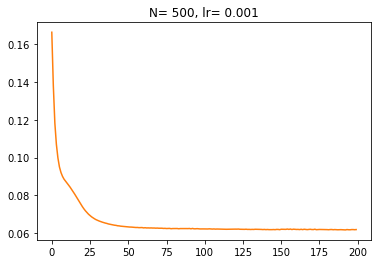

initial train error= 0.002
final train error= 0.0
initial test error= 0.219
final test error= 0.213
Optimization time: 33.03025406600136
[200]Min loss after training alpha : 0.10039101226296226


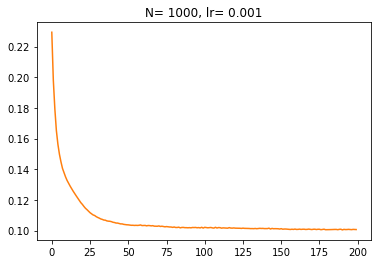

initial train error= 0.038
final train error= 0.0
initial test error= 0.205
final test error= 0.197
Optimization time: 53.50059723800223
[200]Min loss after training alpha : 0.1301755902804879


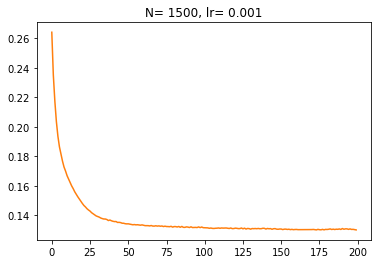

initial train error= 0.059
final train error= 0.0
initial test error= 0.192
final test error= 0.183
Optimization time: 67.30114225699799
[200]Min loss after training alpha : 0.1470349264423036


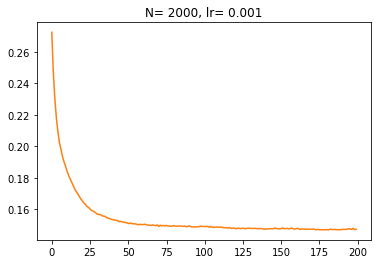

initial train error= 0.081
final train error= 0.0
initial test error= 0.184
final test error= 0.171
Optimization time: 88.39468684299936
[200]Min loss after training alpha : 0.16481898018947985


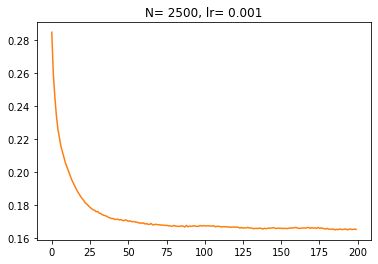

initial train error= 0.093
final train error= 0.004
initial test error= 0.184
final test error= 0.163
Optimization time: 109.60025616100029
[200]Min loss after training alpha : 0.17953431036120027


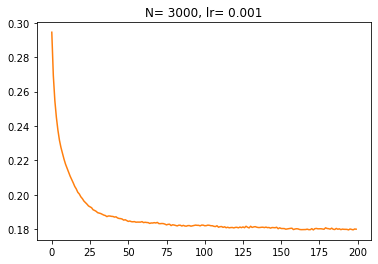

initial train error= 0.105
final train error= 0.007
initial test error= 0.183
final test error= 0.159
Optimization time: 118.57654885500233
[200]Min loss after training alpha : 0.18667204726132694


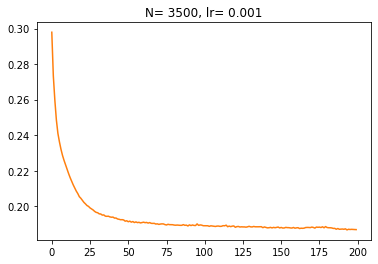

initial train error= 0.115
final train error= 0.01
initial test error= 0.182
final test error= 0.157
Optimization time: 138.38438385700283
[200]Min loss after training alpha : 0.19537557401484126


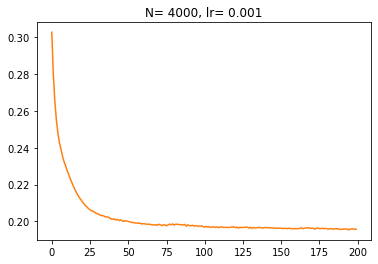

initial train error= 0.12
final train error= 0.017
initial test error= 0.181
final test error= 0.155
Optimization time: 159.78442182199797
[200]Min loss after training alpha : 0.2002444542588011


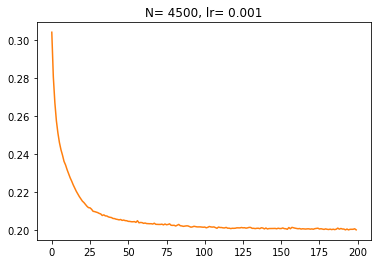

initial train error= 0.119
final train error= 0.023
initial test error= 0.181
final test error= 0.152
Optimization time: 181.1820162820004
[200]Min loss after training alpha : 0.20279497634693472


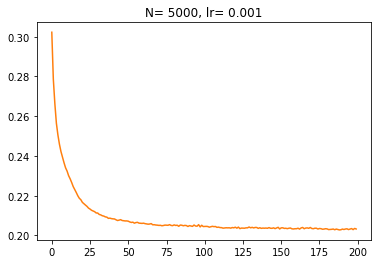

initial train error= 0.119
final train error= 0.026
initial test error= 0.18
final test error= 0.155
Optimization time: 204.05912481300038
[200]Min loss after training alpha : 0.06186205528225001


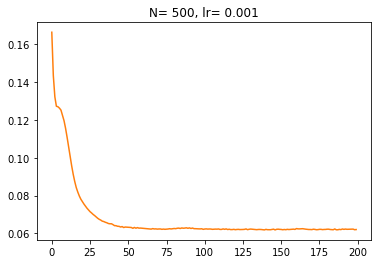

initial train error= 0.002
final train error= 0.0
initial test error= 0.219
final test error= 0.217
Optimization time: 47.783105703005276
[200]Min loss after training alpha : 0.1011705826266571


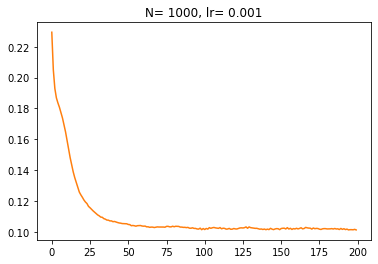

initial train error= 0.038
final train error= 0.0
initial test error= 0.205
final test error= 0.202
Optimization time: 72.32721964999655
[200]Min loss after training alpha : 0.13050757262487428


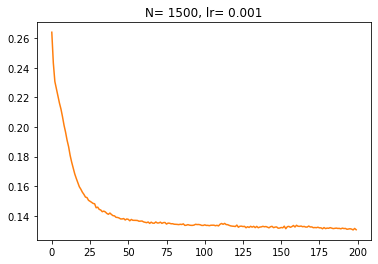

initial train error= 0.059
final train error= 0.0
initial test error= 0.192
final test error= 0.184
Optimization time: 99.55317905000265
[200]Min loss after training alpha : 0.14940565955294527


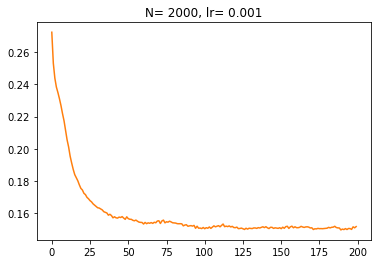

initial train error= 0.081
final train error= 0.002
initial test error= 0.184
final test error= 0.172
Optimization time: 122.94187146000331
[200]Min loss after training alpha : 0.1664852510258688


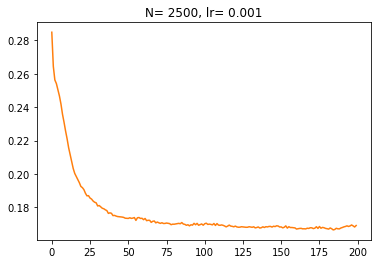

initial train error= 0.093
final train error= 0.004
initial test error= 0.184
final test error= 0.165
Optimization time: 147.77757011399808
[200]Min loss after training alpha : 0.18074447057002174


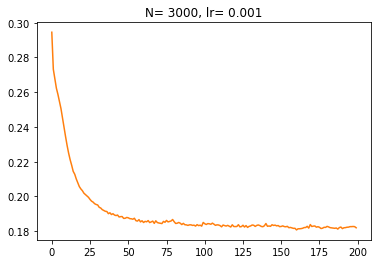

initial train error= 0.105
final train error= 0.009
initial test error= 0.183
final test error= 0.16
Optimization time: 175.36166878499353
[200]Min loss after training alpha : 0.18829334518177704


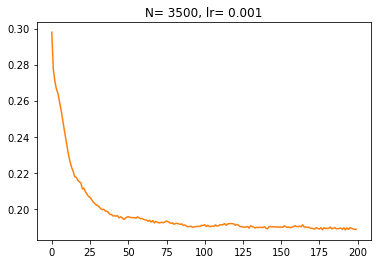

initial train error= 0.115
final train error= 0.012
initial test error= 0.182
final test error= 0.158
Optimization time: 210.41713968800468
[200]Min loss after training alpha : 0.19685982173392047


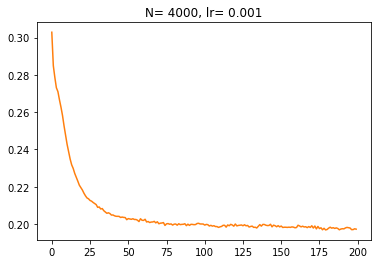

initial train error= 0.12
final train error= 0.017
initial test error= 0.181
final test error= 0.157
Optimization time: 236.61497095999948
[200]Min loss after training alpha : 0.20203230906596875


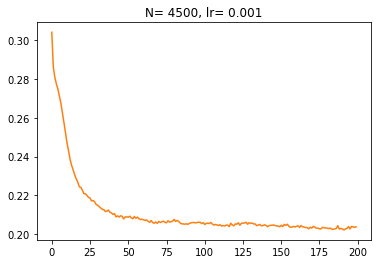

initial train error= 0.119
final train error= 0.024
initial test error= 0.181
final test error= 0.151
Optimization time: 258.34718058800354
[200]Min loss after training alpha : 0.20431656567507747


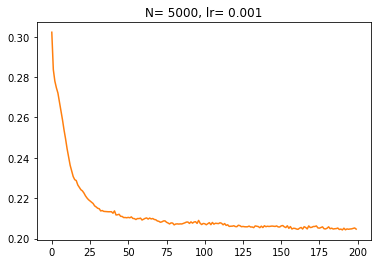

initial train error= 0.119
final train error= 0.027
initial test error= 0.18
final test error= 0.154
Optimization time: 291.898610035998
[200]Min loss after training alpha : 0.06302170693400044


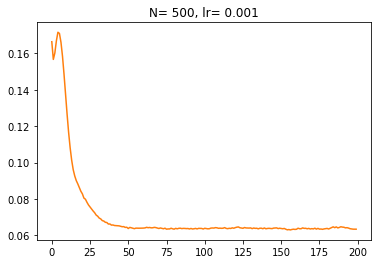

initial train error= 0.002
final train error= 0.0
initial test error= 0.219
final test error= 0.22
Optimization time: 61.964095959003316
[200]Min loss after training alpha : 0.10377934839171053


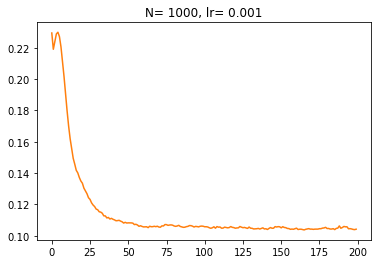

initial train error= 0.038
final train error= 0.0
initial test error= 0.205
final test error= 0.203
Optimization time: 94.51242210900091
[200]Min loss after training alpha : 0.1343515894558523


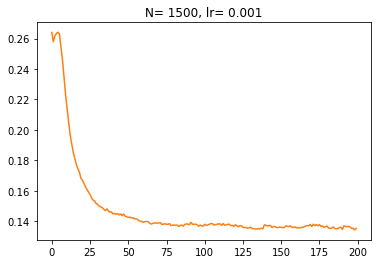

initial train error= 0.059
final train error= 0.0
initial test error= 0.192
final test error= 0.184
Optimization time: 122.11166193499957
[200]Min loss after training alpha : 0.1533840357161917


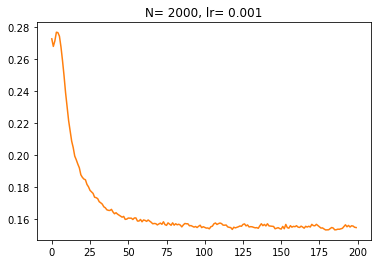

initial train error= 0.081
final train error= 0.003
initial test error= 0.184
final test error= 0.174
Optimization time: 153.93352815300022
[200]Min loss after training alpha : 0.17207021193710192


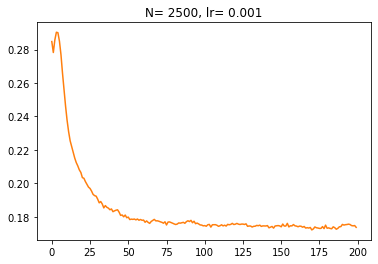

initial train error= 0.093
final train error= 0.006
initial test error= 0.184
final test error= 0.167
Optimization time: 180.7009164359988
[200]Min loss after training alpha : 0.1851021910658947


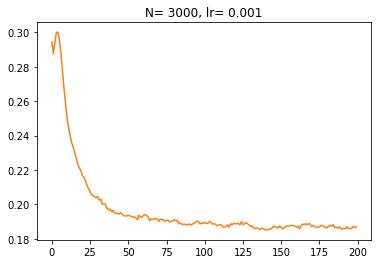

initial train error= 0.105
final train error= 0.012
initial test error= 0.183
final test error= 0.161
Optimization time: 412.4180003799993
[200]Min loss after training alpha : 0.1928091940374418


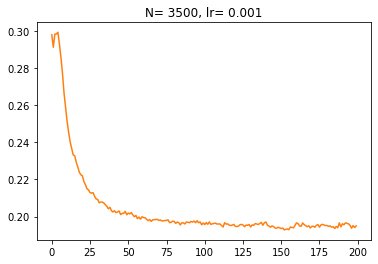

initial train error= 0.115
final train error= 0.015
initial test error= 0.182
final test error= 0.159
Optimization time: 576.3010404710003
[200]Min loss after training alpha : 0.20216846919267073


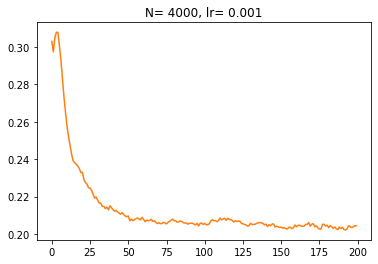

initial train error= 0.12
final train error= 0.021
initial test error= 0.181
final test error= 0.154
Optimization time: 401.6992913330032
[200]Min loss after training alpha : 0.2064232111899596


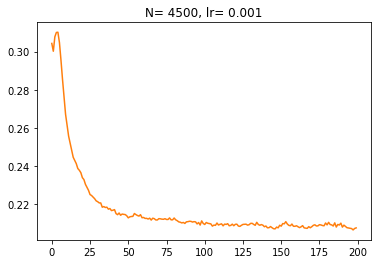

initial train error= 0.119
final train error= 0.026
initial test error= 0.181
final test error= 0.153
Optimization time: 458.58336852100183
[200]Min loss after training alpha : 0.20863801261095097


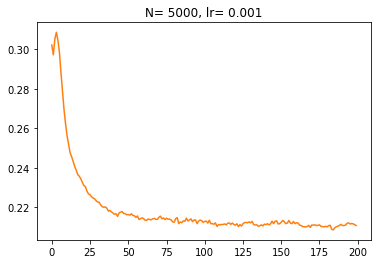

initial train error= 0.119
final train error= 0.031
initial test error= 0.18
final test error= 0.155
Optimization time: 557.2616484699975
[200]Min loss after training alpha : 0.08374707460295425


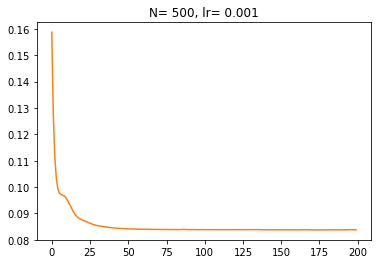

initial train error= 0.002
final train error= 0.0
initial test error= 0.237
final test error= 0.233
Optimization time: 49.32592724999995
[200]Min loss after training alpha : 0.13876589224161154


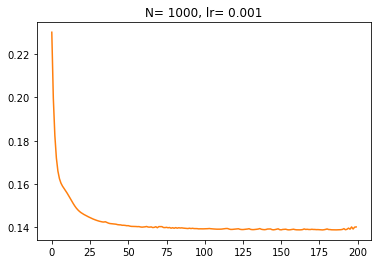

initial train error= 0.038
final train error= 0.001
initial test error= 0.215
final test error= 0.198
Optimization time: 87.51795824700093
[200]Min loss after training alpha : 0.1754197406762894


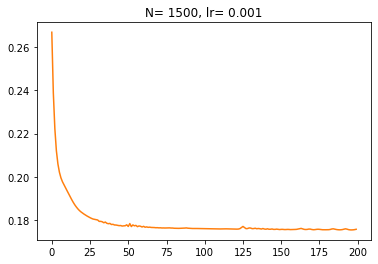

initial train error= 0.075
final train error= 0.006
initial test error= 0.202
final test error= 0.186
Optimization time: 150.20274143999995
[200]Min loss after training alpha : 0.1922232210940992


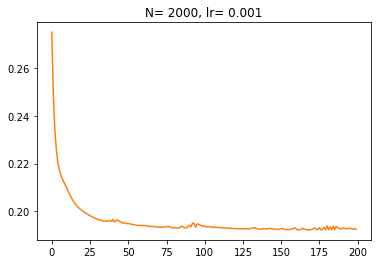

initial train error= 0.089
final train error= 0.018
initial test error= 0.2
final test error= 0.175
Optimization time: 264.2995253150002
[200]Min loss after training alpha : 0.21047046016140208


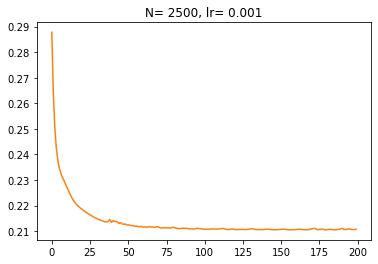

initial train error= 0.109
final train error= 0.035
initial test error= 0.195
final test error= 0.169
Optimization time: 147.11623323700042
[200]Min loss after training alpha : 0.22400440245987152


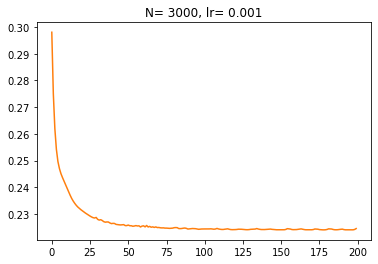

initial train error= 0.117
final train error= 0.045
initial test error= 0.193
final test error= 0.164
Optimization time: 183.55412560100376
[200]Min loss after training alpha : 0.22962557990501425


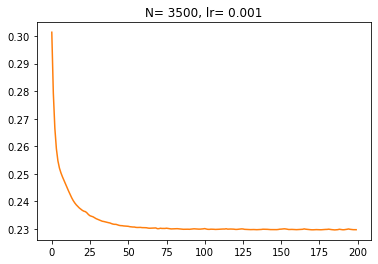

initial train error= 0.122
final train error= 0.052
initial test error= 0.19
final test error= 0.164
Optimization time: 195.20890412299923
[200]Min loss after training alpha : 0.23624618166208086


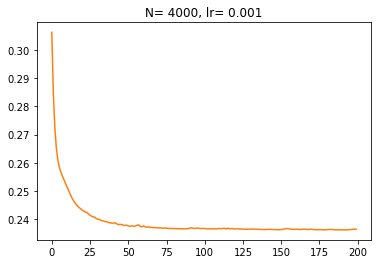

initial train error= 0.125
final train error= 0.06
initial test error= 0.192
final test error= 0.163
Optimization time: 222.87737560999813
[200]Min loss after training alpha : 0.23987911940620948


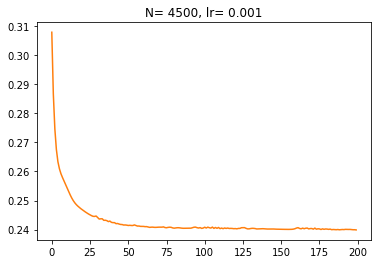

initial train error= 0.127
final train error= 0.067
initial test error= 0.19
final test error= 0.163
Optimization time: 272.9803499660047
[200]Min loss after training alpha : 0.23871551270770755


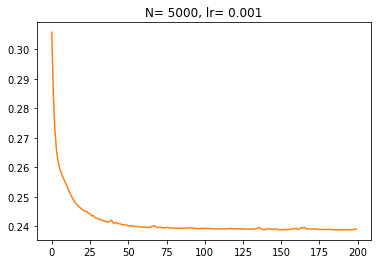

initial train error= 0.126
final train error= 0.074
initial test error= 0.192
final test error= 0.164
Optimization time: 303.53176026800065
[200]Min loss after training alpha : 0.08066953183452975


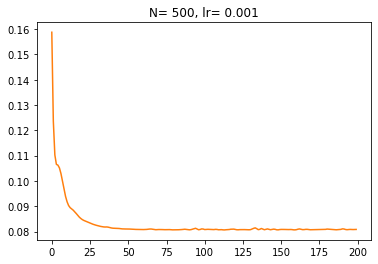

initial train error= 0.002
final train error= 0.0
initial test error= 0.237
final test error= 0.234
Optimization time: 70.34953053799836
[200]Min loss after training alpha : 0.13404733735174626


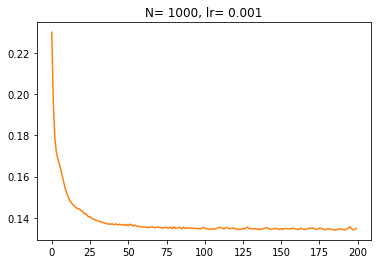

initial train error= 0.038
final train error= 0.001
initial test error= 0.215
final test error= 0.201
Optimization time: 118.62161119200027
[200]Min loss after training alpha : 0.16977515535370696


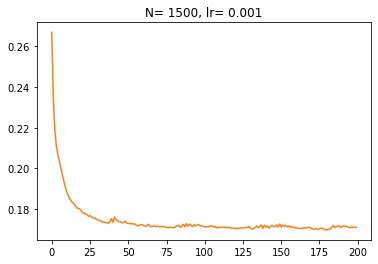

initial train error= 0.075
final train error= 0.004
initial test error= 0.202
final test error= 0.188
Optimization time: 153.8374662819988
[200]Min loss after training alpha : 0.18743905786579856


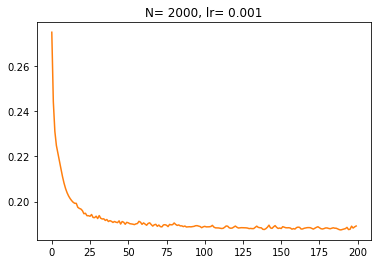

initial train error= 0.089
final train error= 0.012
initial test error= 0.2
final test error= 0.178
Optimization time: 191.24785875200178
[200]Min loss after training alpha : 0.20558488287716997


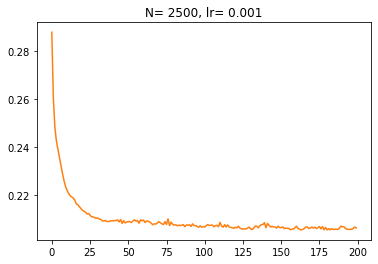

initial train error= 0.109
final train error= 0.028
initial test error= 0.195
final test error= 0.168
Optimization time: 231.9831153030027
[200]Min loss after training alpha : 0.21960626134457012


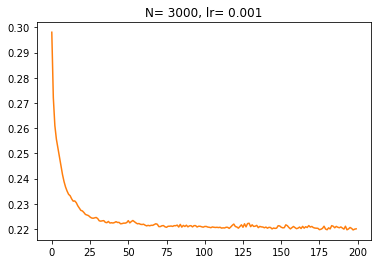

initial train error= 0.117
final train error= 0.038
initial test error= 0.193
final test error= 0.162
Optimization time: 275.8500364309948
[200]Min loss after training alpha : 0.22559964246323247


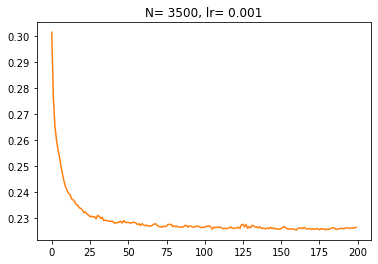

initial train error= 0.122
final train error= 0.049
initial test error= 0.19
final test error= 0.164
Optimization time: 326.8953463899961
[200]Min loss after training alpha : 0.23213377572509156


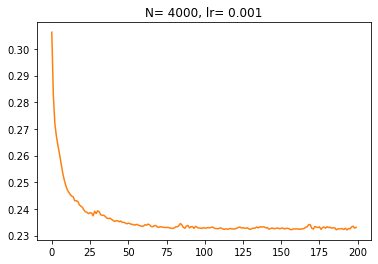

initial train error= 0.125
final train error= 0.053
initial test error= 0.192
final test error= 0.162
Optimization time: 354.4408380869936
[200]Min loss after training alpha : 0.23579314598783038


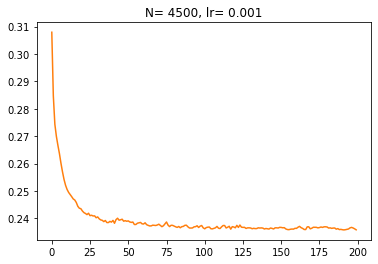

initial train error= 0.127
final train error= 0.065
initial test error= 0.19
final test error= 0.161
Optimization time: 259.55547077899973
[200]Min loss after training alpha : 0.23553041062708296


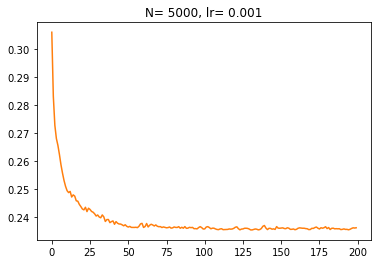

initial train error= 0.126
final train error= 0.071
initial test error= 0.192
final test error= 0.159
Optimization time: 279.7842524040025
[200]Min loss after training alpha : 0.07943612379721937


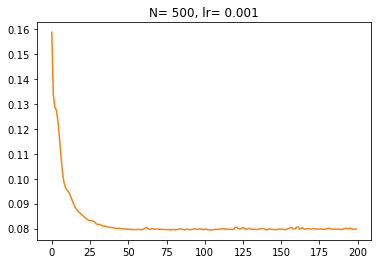

initial train error= 0.002
final train error= 0.0
initial test error= 0.237
final test error= 0.239
Optimization time: 57.826668047004205
[200]Min loss after training alpha : 0.13280337859702296


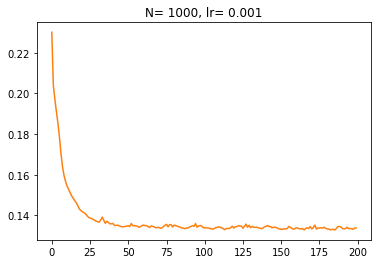

initial train error= 0.038
final train error= 0.001
initial test error= 0.215
final test error= 0.2
Optimization time: 90.53163782099728
[200]Min loss after training alpha : 0.16791166313645597


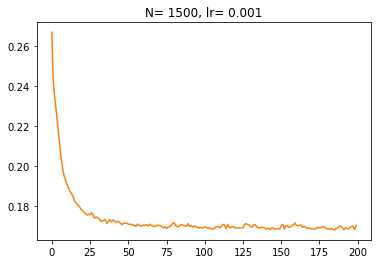

initial train error= 0.075
final train error= 0.003
initial test error= 0.202
final test error= 0.188
Optimization time: 123.74572355000419
[200]Min loss after training alpha : 0.1857456053552905


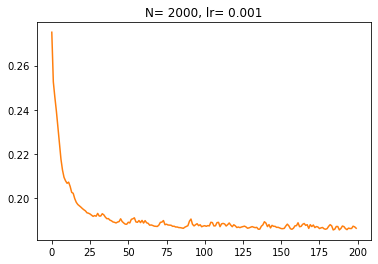

initial train error= 0.089
final train error= 0.012
initial test error= 0.2
final test error= 0.176
Optimization time: 163.89260137100064
[200]Min loss after training alpha : 0.20493864955248164


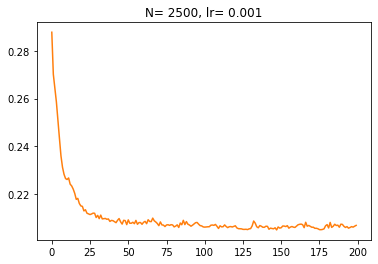

initial train error= 0.109
final train error= 0.026
initial test error= 0.195
final test error= 0.168
Optimization time: 188.50841304400092
[200]Min loss after training alpha : 0.2180384364559136


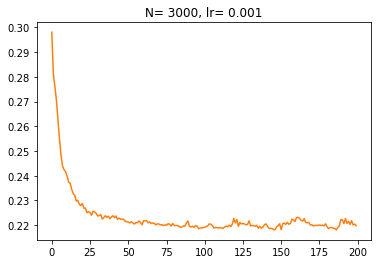

initial train error= 0.117
final train error= 0.038
initial test error= 0.193
final test error= 0.163
Optimization time: 217.99307395199867
[200]Min loss after training alpha : 0.22417811986002678


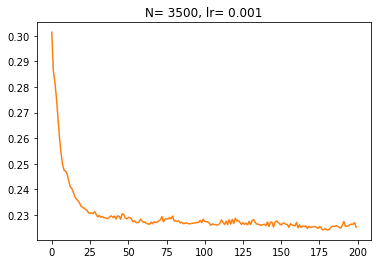

initial train error= 0.122
final train error= 0.045
initial test error= 0.19
final test error= 0.166
Optimization time: 252.93075806699926
[200]Min loss after training alpha : 0.23174271205104274


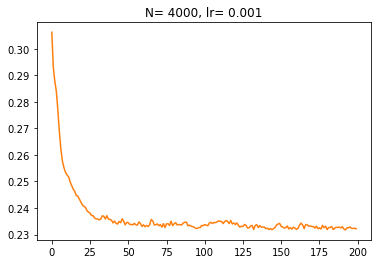

initial train error= 0.125
final train error= 0.054
initial test error= 0.192
final test error= 0.161
Optimization time: 285.3347510140011
[200]Min loss after training alpha : 0.23443544219689888


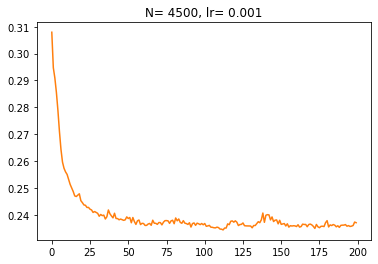

initial train error= 0.127
final train error= 0.061
initial test error= 0.19
final test error= 0.159
Optimization time: 321.0351429259972
[200]Min loss after training alpha : 0.23496549246618814


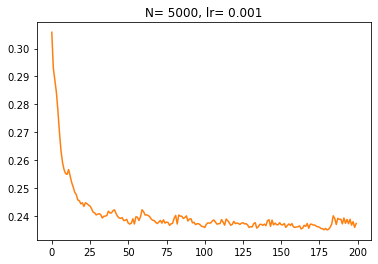

initial train error= 0.126
final train error= 0.069
initial test error= 0.192
final test error= 0.161
Optimization time: 367.59379195400106
[200]Min loss after training alpha : 0.3167024540206598


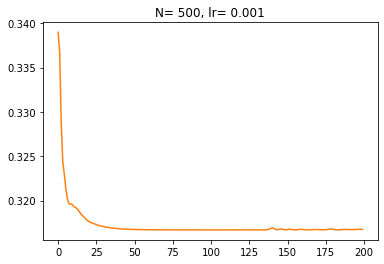

initial train error= 0.078
final train error= 0.062
initial test error= 0.23
final test error= 0.226
Optimization time: 32.05071809000219
[200]Min loss after training alpha : 0.35923756266471446


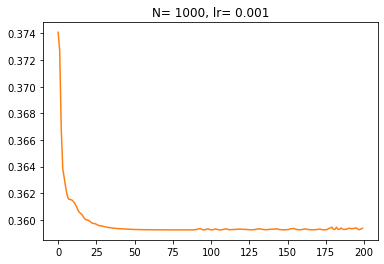

initial train error= 0.126
final train error= 0.11
initial test error= 0.226
final test error= 0.223
Optimization time: 53.520373923005536
[200]Min loss after training alpha : 0.381931042059119


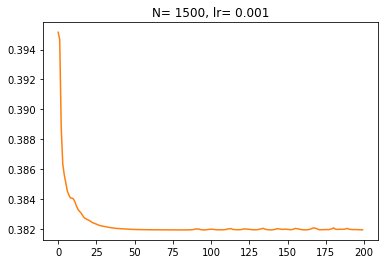

initial train error= 0.16
final train error= 0.141
initial test error= 0.224
final test error= 0.218
Optimization time: 68.69632546699722
[200]Min loss after training alpha : 0.3816571801698924


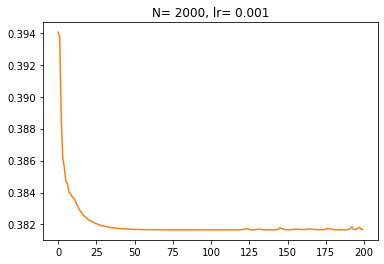

initial train error= 0.156
final train error= 0.148
initial test error= 0.223
final test error= 0.218
Optimization time: 86.56161967699882
[200]Min loss after training alpha : 0.3887091966862323


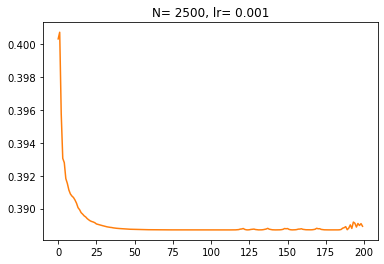

initial train error= 0.17
final train error= 0.162
initial test error= 0.218
final test error= 0.213
Optimization time: 105.24903715500113
[200]Min loss after training alpha : 0.39545688678720176


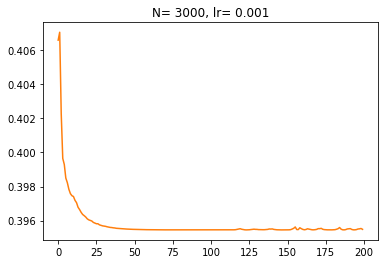

initial train error= 0.173
final train error= 0.167
initial test error= 0.219
final test error= 0.213
Optimization time: 123.5732162830027
[200]Min loss after training alpha : 0.39603325743797213


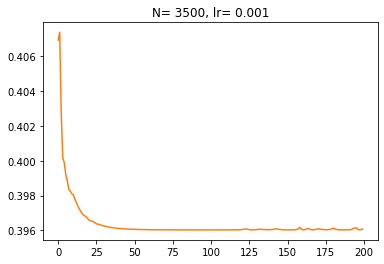

initial train error= 0.174
final train error= 0.165
initial test error= 0.218
final test error= 0.211
Optimization time: 143.89328133999516
[200]Min loss after training alpha : 0.3992995214029245


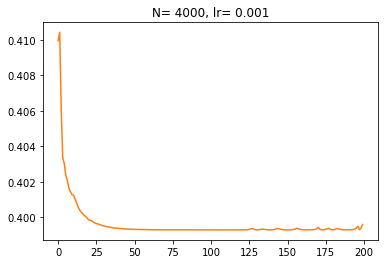

initial train error= 0.184
final train error= 0.172
initial test error= 0.218
final test error= 0.21
Optimization time: 162.1765547479954
[200]Min loss after training alpha : 0.3992554259405166


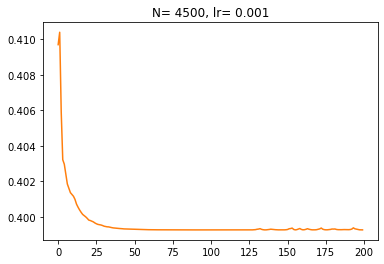

initial train error= 0.182
final train error= 0.173
initial test error= 0.218
final test error= 0.211
Optimization time: 180.12964194599772
[200]Min loss after training alpha : 0.3956689371572218


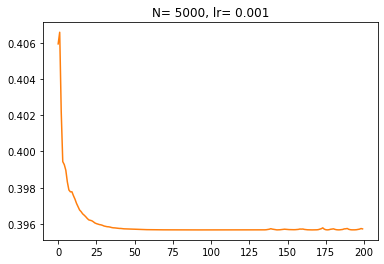

initial train error= 0.18
final train error= 0.17
initial test error= 0.219
final test error= 0.212
Optimization time: 201.41925142800028
[200]Min loss after training alpha : 0.31618492229116046


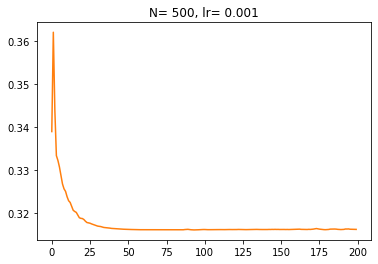

initial train error= 0.078
final train error= 0.06
initial test error= 0.23
final test error= 0.226
Optimization time: 47.13180220800132
[200]Min loss after training alpha : 0.35889876916466246


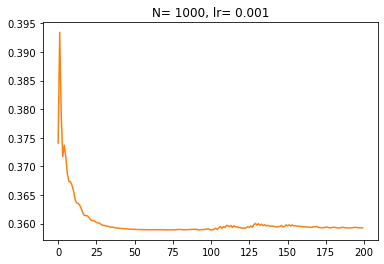

initial train error= 0.126
final train error= 0.11
initial test error= 0.226
final test error= 0.221
Optimization time: 71.91106466800557
[200]Min loss after training alpha : 0.3820415476754481


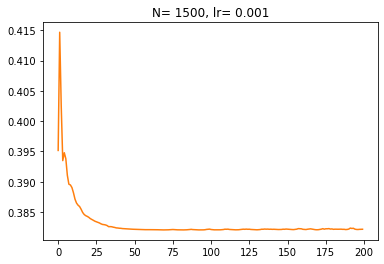

initial train error= 0.16
final train error= 0.14
initial test error= 0.224
final test error= 0.218
Optimization time: 101.19728347100317
[200]Min loss after training alpha : 0.3816222429995639


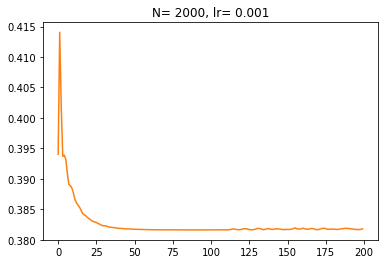

initial train error= 0.156
final train error= 0.145
initial test error= 0.223
final test error= 0.218
Optimization time: 123.71777852899686
[200]Min loss after training alpha : 0.38888587398944935


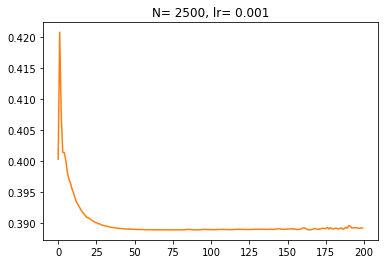

initial train error= 0.17
final train error= 0.16
initial test error= 0.218
final test error= 0.214
Optimization time: 151.99549864699657
[200]Min loss after training alpha : 0.3956401850301851


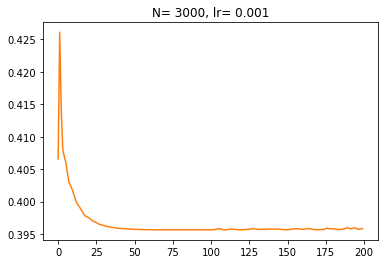

initial train error= 0.173
final train error= 0.167
initial test error= 0.219
final test error= 0.213
Optimization time: 178.31811445800122
[200]Min loss after training alpha : 0.396155078318499


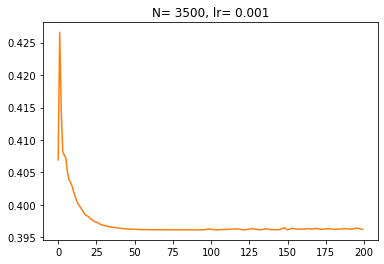

initial train error= 0.174
final train error= 0.165
initial test error= 0.218
final test error= 0.211
Optimization time: 208.58760324500327
[200]Min loss after training alpha : 0.3993396758904051


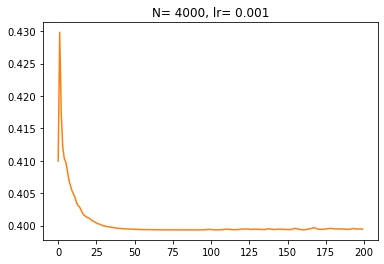

initial train error= 0.184
final train error= 0.171
initial test error= 0.218
final test error= 0.21
Optimization time: 236.2531217269934
[200]Min loss after training alpha : 0.39917502233338376


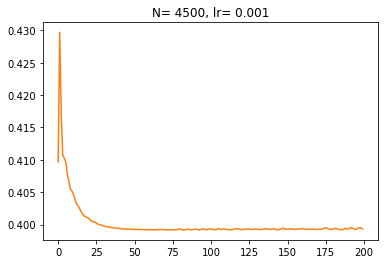

initial train error= 0.182
final train error= 0.173
initial test error= 0.218
final test error= 0.211
Optimization time: 294.37903253699915
[200]Min loss after training alpha : 0.3958381073781812


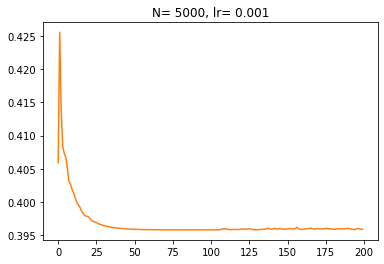

initial train error= 0.18
final train error= 0.169
initial test error= 0.219
final test error= 0.212
Optimization time: 324.0234402319984
[200]Min loss after training alpha : 0.31571361919524155


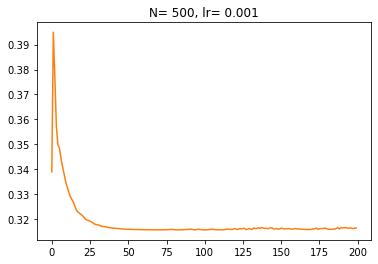

initial train error= 0.078
final train error= 0.06
initial test error= 0.23
final test error= 0.226
Optimization time: 68.40959699000086
[200]Min loss after training alpha : 0.3589545088442528


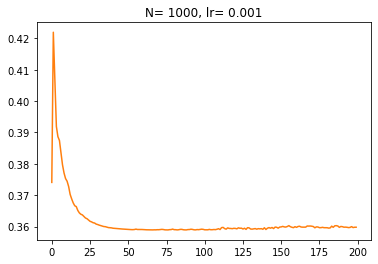

initial train error= 0.126
final train error= 0.109
initial test error= 0.226
final test error= 0.221
Optimization time: 109.72806722999667
[200]Min loss after training alpha : 0.3817910429691146


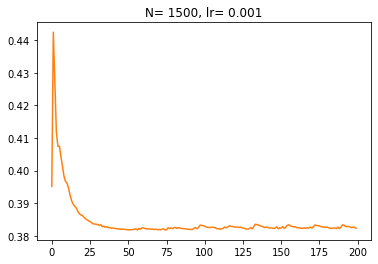

initial train error= 0.16
final train error= 0.141
initial test error= 0.224
final test error= 0.218
Optimization time: 136.75485891699645
[200]Min loss after training alpha : 0.3816575974716331


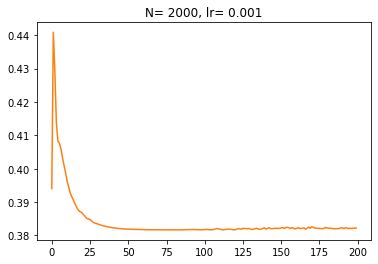

initial train error= 0.156
final train error= 0.146
initial test error= 0.223
final test error= 0.217
Optimization time: 180.44158835800044
[200]Min loss after training alpha : 0.3884529388530263


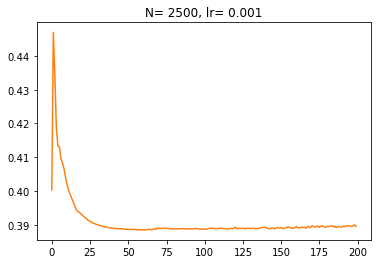

initial train error= 0.17
final train error= 0.159
initial test error= 0.218
final test error= 0.214
Optimization time: 221.16070188699814
[200]Min loss after training alpha : 0.395651610890411


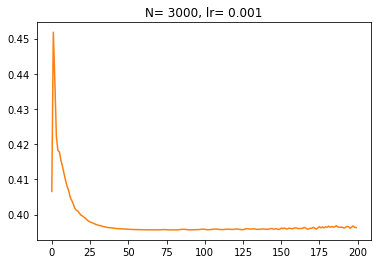

initial train error= 0.173
final train error= 0.165
initial test error= 0.219
final test error= 0.212
Optimization time: 259.90431880300457
[200]Min loss after training alpha : 0.39617096573765576


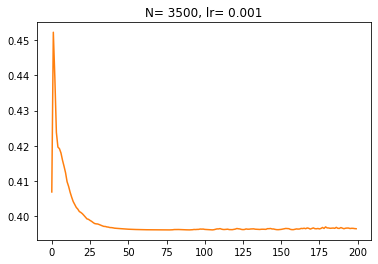

initial train error= 0.174
final train error= 0.166
initial test error= 0.218
final test error= 0.211
Optimization time: 296.70419238299655
[200]Min loss after training alpha : 0.39934652279346333


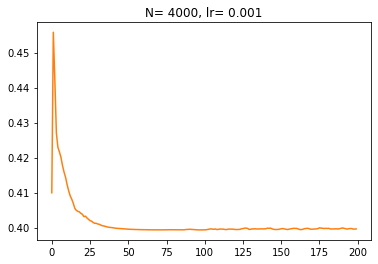

initial train error= 0.184
final train error= 0.172
initial test error= 0.218
final test error= 0.211
Optimization time: 338.61649733399827
[200]Min loss after training alpha : 0.3992153347213422


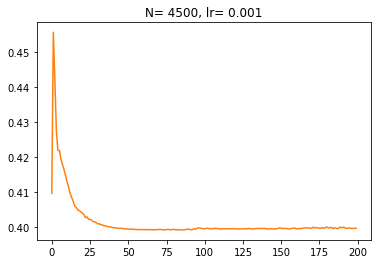

initial train error= 0.182
final train error= 0.174
initial test error= 0.218
final test error= 0.211
Optimization time: 377.61604404100217
[200]Min loss after training alpha : 0.3957695140226691


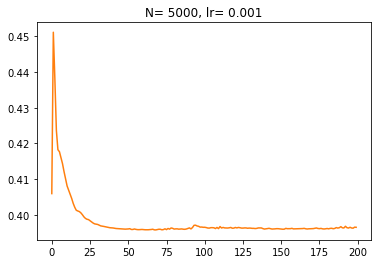

initial train error= 0.18
final train error= 0.171
initial test error= 0.219
final test error= 0.211
Optimization time: 427.7008472640009


In [121]:
gamma2=0.01
nu=0.01


p = 784 # vx_train.shape[1]
D1 = p + 1
D2 = 784

Layers=[1,2,3]


random1="false"
random2="true"


# activ = relu

activ="relu"

alpha1min_list_fash_relu = []
loss_list_fash_relu = []
train_list_fash_relu = []
test_list_fash_relu = []



for l in Layers:
    
    L=l
    alpha1min_list = []
    loss_list = []
    train_loss = []
    test_loss = []
    opt_time = []


    for rate in np.arange(0.1,1.1,0.1):

        start = time.perf_counter()

        # get the data
        loadmnist=False 
        (vx_train, y_train), (vx_test, y_test) = get_sets(rate)

        Ntrain=vx_train.shape[0]
        Ntest=vx_test.shape[0]

        # optimize over alpha
        lr=0.001
        alpha1min, loss_history = optimize_alpha1(torch.zeros((D1,p,L),dtype=torch.float64),nsteps=200,lr=lr)
        lmin = loss_torch(alpha1min).detach().numpy()

        # append the loss / alpha
        loss_in=loss_torch(torch.zeros((D1,p,L),dtype=torch.float64)).numpy()
        loss_list.append([loss_in,lmin])
        alpha1min_list.append(alpha1min.detach().numpy())


        # append the train/test error
        _,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
        _,alpha2_init=getalpha2_torch(vx_train,y_train)

        inierror_train=get_error(vx_train,y_train,alpha2_init)
        finerror_train=get_error(phi_torch(vx_train,alpha1min),y_train,alpha2min)

        inierror_test=get_error(vx_test,y_test,alpha2_init)
        finerror_test=get_error(phi_torch(vx_test,alpha1min),y_test,alpha2min)

        print('initial {} error= {}'.format("train",np.round(inierror_train,3))) 
        print('final {} error= {}'.format("train",np.round(finerror_train,3)))

        print('initial {} error= {}'.format("test",np.round(inierror_test,3)))
        print('final {} error= {}'.format("test",np.round(finerror_test,3)))

        # append the train/test error
        #inierror_train,finerror_train,inierror_test,finerror_test = get_error(vx_train,y_train,vx_test,y_test)

        train_loss.append(np.array([inierror_train,finerror_train]))
        test_loss.append((np.array([inierror_test,finerror_test])))

        end = time.perf_counter()
        print(f"Optimization time: {end-start}")


    alpha1min_list_fash_relu.append(alpha1min_list)
    loss_list_fash_relu.append(loss_list)
    train_list_fash_relu.append(train_loss)
    test_list_fash_relu.append(test_loss)
    

    
# activ = tanh  

activ="tanh"

alpha1min_list_fash_tanh = []
loss_list_fash_tanh = []
train_list_fash_tanh = []
test_list_fash_tanh = []



for l in Layers:
    
    L=l
    alpha1min_list = []
    loss_list = []
    train_loss = []
    test_loss = []
    opt_time = []


    for rate in np.arange(0.1,1.1,0.1):

        start = time.perf_counter()

        # get the data
        loadmnist=False 
        (vx_train, y_train), (vx_test, y_test) = get_sets(rate)

        Ntrain=vx_train.shape[0]
        Ntest=vx_test.shape[0]

        # optimize over alpha
        lr=0.001
        alpha1min, loss_history = optimize_alpha1(torch.zeros((D1,p,L),dtype=torch.float64),nsteps=200,lr=lr)
        lmin = loss_torch(alpha1min).detach().numpy()

        # append the loss / alpha
        loss_in=loss_torch(torch.zeros((D1,p,L),dtype=torch.float64)).numpy()
        loss_list.append([loss_in,lmin])
        alpha1min_list.append(alpha1min.detach().numpy())


        # append the train/test error
        _,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
        _,alpha2_init=getalpha2_torch(vx_train,y_train)

        inierror_train=get_error(vx_train,y_train,alpha2_init)
        finerror_train=get_error(phi_torch(vx_train,alpha1min),y_train,alpha2min)

        inierror_test=get_error(vx_test,y_test,alpha2_init)
        finerror_test=get_error(phi_torch(vx_test,alpha1min),y_test,alpha2min)

        print('initial {} error= {}'.format("train",np.round(inierror_train,3))) 
        print('final {} error= {}'.format("train",np.round(finerror_train,3)))

        print('initial {} error= {}'.format("test",np.round(inierror_test,3)))
        print('final {} error= {}'.format("test",np.round(finerror_test,3)))

        # append the train/test error
        #inierror_train,finerror_train,inierror_test,finerror_test = get_error(vx_train,y_train,vx_test,y_test)

        train_loss.append(np.array([inierror_train,finerror_train]))
        test_loss.append((np.array([inierror_test,finerror_test])))

        end = time.perf_counter()
        print(f"Optimization time: {end-start}")


    alpha1min_list_fash_tanh.append(alpha1min_list)
    loss_list_fash_tanh.append(loss_list)
    train_list_fash_tanh.append(train_loss)
    test_list_fash_tanh.append(test_loss)
    
    
    

    
# activ = sigmoid  

activ="sigmoid"

alpha1min_list_fash_sigm = []
loss_list_fash_sigm = []
train_list_fash_sigm = []
test_list_fash_sigm = []


    
for l in Layers:
    
    L=l
    alpha1min_list = []
    loss_list = []
    train_loss = []
    test_loss = []
    opt_time = []


    for rate in np.arange(0.1,1.1,0.1):

        start = time.perf_counter()

        # get the data
        loadmnist=False 
        (vx_train, y_train), (vx_test, y_test) = get_sets(rate)

        Ntrain=vx_train.shape[0]
        Ntest=vx_test.shape[0]

        # optimize over alpha
        lr=0.001
        alpha1min, loss_history = optimize_alpha1(torch.zeros((D1,p,L),dtype=torch.float64),nsteps=200,lr=lr)
        lmin = loss_torch(alpha1min).detach().numpy()

        # append the loss / alpha
        loss_in=loss_torch(torch.zeros((D1,p,L),dtype=torch.float64)).numpy()
        loss_list.append([loss_in,lmin])
        alpha1min_list.append(alpha1min.detach().numpy())


        # append the train/test error
        _,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
        _,alpha2_init=getalpha2_torch(vx_train,y_train)

        inierror_train=get_error(vx_train,y_train,alpha2_init)
        finerror_train=get_error(phi_torch(vx_train,alpha1min),y_train,alpha2min)

        inierror_test=get_error(vx_test,y_test,alpha2_init)
        finerror_test=get_error(phi_torch(vx_test,alpha1min),y_test,alpha2min)

        print('initial {} error= {}'.format("train",np.round(inierror_train,3))) 
        print('final {} error= {}'.format("train",np.round(finerror_train,3)))

        print('initial {} error= {}'.format("test",np.round(inierror_test,3)))
        print('final {} error= {}'.format("test",np.round(finerror_test,3)))

        # append the train/test error
        #inierror_train,finerror_train,inierror_test,finerror_test = get_error(vx_train,y_train,vx_test,y_test)

        train_loss.append(np.array([inierror_train,finerror_train]))
        test_loss.append((np.array([inierror_test,finerror_test])))

        end = time.perf_counter()
        print(f"Optimization time: {end-start}")


    alpha1min_list_fash_sigm.append(alpha1min_list)
    loss_list_fash_sigm.append(loss_list)
    train_list_fash_sigm.append(train_loss)
    test_list_fash_sigm.append(test_loss)






In [3]:
#%store -r alpha1min_mnist1L_sigm_Norm

In [148]:
def plot_error_NEW(loss_list,train_list,test_list):
    #N_list = np.array([50,100,200,400,800,1600])
    Layers=np.array([1,2,3])

    N_list=[np.int(rate*5000) for rate in np.arange(0.1,1.1,0.1)]
    fig = plt.figure(figsize=(15,4)) 
    c=1
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:blue','tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    
    plt.subplot(1, 3, c)
    plt.title('Training Error')
    plt.plot(N_list,np.array(train_list[0])[:,0],label='Ridge')
    for train,L in zip(train_list,Layers):
        plt.plot(N_list,np.array(train)[:,1],label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('simlog')
    c+=1

    plt.subplot(1, 3, c)
    plt.title('Testing Error') 
    plt.plot(N_list,np.array(test_list[0])[:,0],label='Ridge')
    for test,L in zip(test_list,Layers):
        plt.plot(N_list,np.array(test)[:,1],label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1

    plt.subplot(1, 3, c)
    plt.title(r"$L_2$ regularized loss")
    plt.plot(N_list,np.array(loss_list[0])[:,0],label='Ridge')
    for l,L in zip(loss_list,Layers):
        plt.plot(N_list,np.array(l)[:,1], label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')

    plt.legend() #loc=(1.04,0.55)
    #plt.tight_layout()

    #activ="sigmoid"
    #dataset="MNIST_fashion"
    #plt.savefig('Error_{}_{}_NEW.pdf'.format(dataset,activ))
    
    



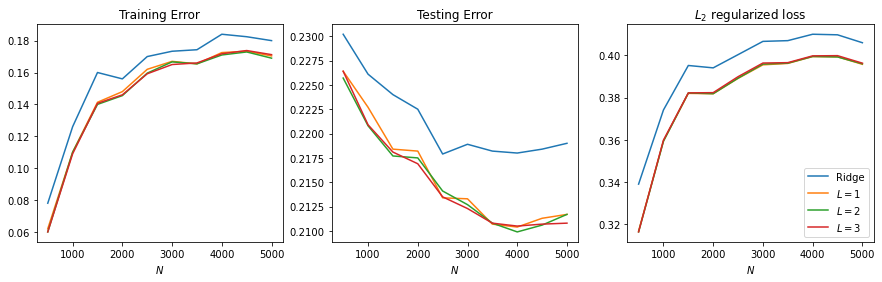

In [149]:
plot_error_NEW(loss_list_fash_sigm,train_list_fash_sigm,test_list_fash_sigm)

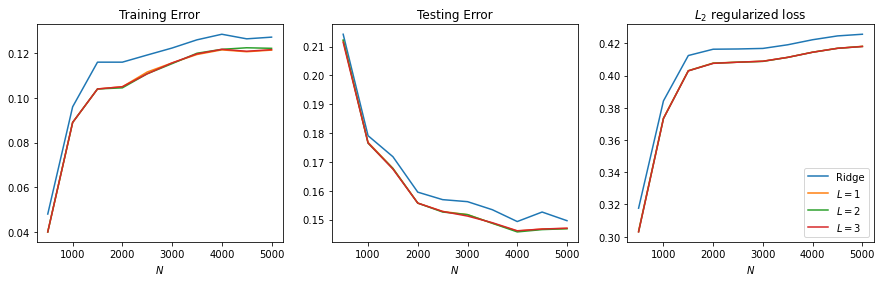

In [144]:
# Old version of error plots 


#activ="sigmoid"

#Error_plot(np.array(train_mnist1L_relu_small)[:,0],np.array(train_mnist1L_relu_small)[:,1],
#         np.array(test_mnist1L_relu_small)[:,0],np.array(test_mnist1L_relu_small)[:,1],
#         np.array(loss_mnist1L_relu_small)[:,0],np.array(loss_mnist1L_relu_small)[:,1],
#         "MNIST1L_lr0.001")

#perc_list = np.arange(10,90,10)
    #N_list = np.array([50,100,200,400,800,1600])
    #N_list = np.arange(10,110,10)
N_list=[np.int(rate*5000) for rate in np.arange(0.1,1.1,0.1)]
fig = plt.figure(figsize=(15,4)) 
c=1

plt.subplot(1, 3, c)
plt.title('Training Error')
plt.plot(N_list,np.array(train_mnist1L_sigm_Norm)[:,0],label='Ridge')
plt.plot(N_list,np.array(train_mnist1L_sigm_Norm)[:,1], label=r'$L = 1$')
plt.plot(N_list,np.array(train_mnist2L_sigm_Norm)[:,1], label=r'$L = 2$')
plt.plot(N_list,np.array(train_mnist3L_sigm_Norm)[:,1], label=r'$L = 3$')
plt.xlabel(r'$N$')
#plt.yscale('simlog')
c+=1

plt.subplot(1, 3, c)
plt.title('Testing Error') 
plt.plot(N_list,np.array(test_mnist1L_sigm_Norm)[:,0],label='Ridge')
plt.plot(N_list,np.array(test_mnist1L_sigm_Norm)[:,1], label=r'$L = 1$')
plt.plot(N_list,np.array(test_mnist2L_sigm_Norm)[:,1], label=r'$L = 2$')
plt.plot(N_list,np.array(test_mnist3L_sigm_Norm)[:,1], label=r'$L = 3$')
plt.xlabel(r'$N$')
#plt.ylabel("Error")
#plt.yscale('log')
c+=1

plt.subplot(1, 3, c)
plt.title(r"$L_2$ regularized loss")
plt.plot(N_list,np.array(loss_mnist1L_sigm_Norm)[:,0],label='Ridge')
plt.plot(N_list,np.array(loss_mnist1L_sigm_Norm)[:,1], label=r'$L = 1$')
plt.plot(N_list,np.array(loss_mnist2L_sigm_Norm)[:,1], label=r'$L = 2$')
plt.plot(N_list,np.array(loss_mnist3L_sigm_Norm)[:,1], label=r'$L = 3$')
plt.xlabel(r'$N$')
#plt.yscale('log')


plt.legend()
#plt.tight_layout()


dataset="MNIST"
#plt.savefig('Error_{}_{}_NEW.pdf'.format(dataset,activ))
plt.show()

In [20]:

from cycler import cycler

def alpha(alpha_relu,alpha_tanh,alpha_sigm):#,alpha_sigm):
    Layers=[1,2,3]
    c=1
    fig = plt.figure(figsize=(15,4)) 
    Ntrain=5000
    N_list=[np.int(rate*Ntrain) for rate in np.arange(0.1,1.1,0.1)]
    #N_list = np.array([50,100,200,400,800,1600])
    
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    plt.subplot(1, 3, c)
    #plt.title('ReLU')
    for alpha1min, L in zip(alpha_relu,Layers):
        alpha1norm=L*np.sum(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
        
        plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1
    
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    plt.subplot(1, 3, c)
    for alpha1min, L in zip(alpha_tanh,Layers):
        alpha1norm=L*np.sum(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
        plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1
    
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    plt.subplot(1, 3, c)
    for alpha1min, L in zip(alpha_sigm,Layers):
        alpha1norm=L*np.sum(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
        plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1
    
    #plt.subplot(1, 3, c)
    #for alpha1min, L in zip(alpha_sigm,Layers):
    #    alpha1norm=np.mean(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
    #    plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    #plt.xlabel(r'$N_{train}$')
    #c+=1
    
    plt.legend()

    #dataset="MNIST_fashion"

    #plt.savefig(f'alpha1_NEW_{dataset}.pdf')
    plt.show()

    #plt.tight_layout()

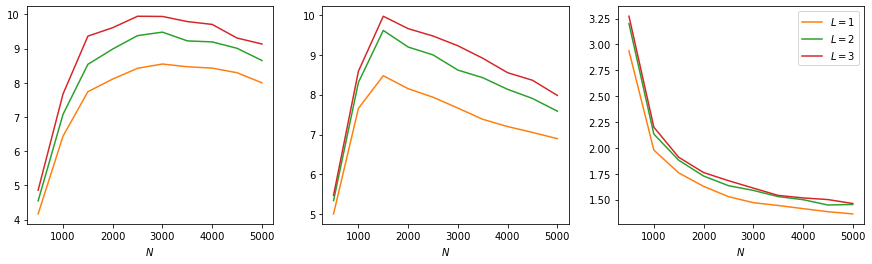

In [21]:
alpha(alpha1min_list_fash_relu,alpha1min_list_fash_tanh,
      alpha1min_list_fash_sigm)#,alpha1min_list_synt_sigm)

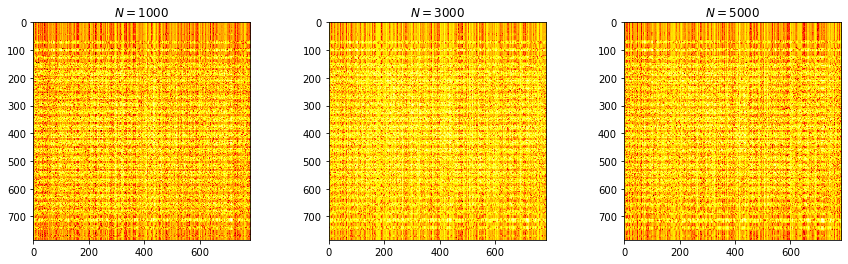

In [161]:
from matplotlib.colors import LogNorm

alpha1_avg=np.mean(np.array(alpha1_mnist3L_sigm_Norm)**2,axis=3) 


fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 4)
for i, ax in zip(np.arange(1,10,4), axes):
    ax.imshow(np.log(alpha1_avg[i,:,:]), cmap='hot',interpolation='nearest')
    #,norm=LogNorm(vmin=1e-5, vmax=1))#interpolation='nearest')
    ax.set_title(f'$N={(i+1)*500}$')
    #ax.set_xticks([])
    #ax.set_yticks([])

#plt.tight_layout()
#plt.colorbar(im, cax=axes[4])
activ="sigmoid"
dataset="MNIST_fash"
#plt.savefig('heatplot3L_notLog{}_{}.pdf'.format(dataset,activ))
plt.show()

#c=1
#fig=plt.figure(figsize=(20,4)) 

#for i in np.arange(1,2,10):
#    plt.subplot(1,5,c)
#    plt.imshow(
#    c+=1
#    plt.colorbar()
#    plt.show()

In [4]:
#%store -r alpha1min_list_fash_sigm

## 2) Regularization with CIFAR-10  (to complete)


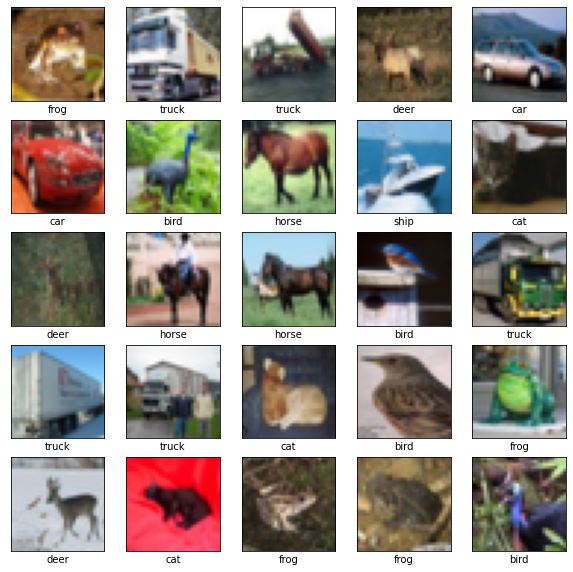

In [13]:
def LoadCIFAR():
    Ntrain=5000
    Ntest=10000
    cifar10 = tf.keras.datasets.cifar10
    class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train=x_train.astype('float64')
    x_test=x_test.astype('float64')
    x_train=x_train[0:Ntrain,:,:]
    y_train=y_train[0:Ntrain]
    x_test=x_test[0:Ntest,:,:]
    y_test=y_test[0:Ntest]
    Y_train=np.zeros((Ntrain,10))
    Y_test=np.zeros((Ntest,10))
    for i in range(10):
        Y_train[y_train[0:Ntrain,0]==i,i]=1
        Y_test[y_test[0:Ntest,0]==i,i]=1
    x_train, x_test = x_train / 255.0, x_test / 255.0
    normalizedata=False
    if normalizedata:
        a=np.sqrt(np.sum(x_train*x_train,(1,2)))
        a=a[:,None,None]+np.zeros((Ntrain,32,32))
        x_train = np.divide(x_train , a)
        a=np.sqrt(np.sum(x_test*x_test,(1,2)))
        a=a[:,None,None]+np.zeros((Ntest,32,32))
        x_test = np.divide(x_test , a)
        a=0 
    show=True
    if show == True:
        def showimages(x_train,y_train):
            plt.figure(figsize=(10,10))
            for i in range(25):
                plt.subplot(5,5,i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(x_train[i], cmap=plt.cm.binary)
                plt.xlabel(class_names[y_train[i,0]])
            plt.show()
        showimages(x_train,y_train)
    d2=32*32*3
    vx_train=np.reshape(x_train,(Ntrain,d2))
    vx_test=np.reshape(x_test,(Ntest,d2))
    return (vx_train,Y_train,vx_test,Y_test)

(X_train,Y_train,X_test,Y_test) = LoadCIFAR()

In [15]:
Ntrain=5000
def get_sets_CIFAR(rate):
    vx_train=X_train[0:np.int(rate*Ntrain),:]
    y_train=Y_train[0:np.int(rate*Ntrain),:]

    vx_train=torch.tensor(vx_train.astype('float64'))
    vx_test=torch.tensor(X_test.astype('float64'))
    y_train=torch.tensor(y_train.astype('float64'))
    y_test=torch.tensor(Y_test.astype('float64'))

    return (vx_train, y_train), (vx_test, y_test)


rate=0.5
(vx_train, y_train), (vx_test, y_test) = get_sets_CIFAR(rate)

In [16]:
def phi_reg(x,alpha1,z): #added slack variable z
    for i in range(L):
        xtopsi1_transp=torch.transpose(xtopsi1_torch(x),0,1)
        x=x+torch.matmul(xtopsi1_transp,alpha1[:,:,i])+z[:,:,i]
    return x

In [17]:
def loss_reg(alpha1,z):
    loss1=torch.sum(alpha1*alpha1) + (1/r)*torch.sum(z*z) #update the loss 
    loss1=0.5*L*loss1
    phivx_train=phi_reg(vx_train,alpha1,z)
#    phivx_train=vx_train
    (loss2,alpha2)=getalpha2_torch(phivx_train,y_train)
    return nu*loss1+loss2

In [20]:
def optim_alpha1_reg(rate,nsteps=1000,lr=0.1):
    alpha1_init=torch.zeros((D1,p,L),dtype=torch.float64)
    z_init=torch.zeros((np.int(rate*Ntrain),p,L),dtype=torch.float64)
    alpha1 = Variable(alpha1_init,requires_grad=True)
    z=Variable(z_init,requires_grad=True)
    opt = torch.optim.Adam([alpha1,z],lr=lr)

    loss_history = []

    for i in range(nsteps):
        opt.zero_grad()
        stdout.write("\r[%s]" % (i+1)) 
        loss = loss_reg(alpha1,z) # Calculate loss function
        loss_history.append(loss.detach().numpy()) # Do some recordings for plots
        
        loss.backward()
        opt.step()
        
       # if i % 50 == 0:
       #     print(f'iter {i+1}: loss = {loss}')
    
    #print(f'final loss: loss = {loss}')

    print(r"Min loss after training alpha and z: {}".format(np.min(loss_history)))

    plt.figure()    
    plt.plot(loss_history)                   #plot the loss as a function of iteration i
    plt.title('N= {}, lr= {}'.format(len(vx_train),lr))
    plt.show()
    
    return alpha1, z

        #stdout.write("\r[%s]" % loss) 




[100]Min loss after training alpha and z: 0.64096539436342


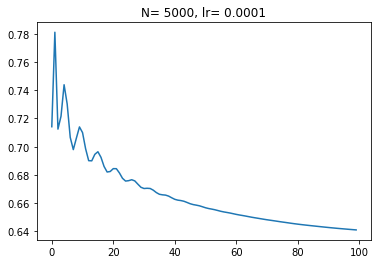

In [23]:
gamma2=0.01
nu=0.01
r=0.01
L=1

p = vx_train.shape[1]
#D1 = p + 1
D1=200
#D2 = vx_train.shape[1]
D2=800


random1="true"
random2="true"
activ="relu"

Ntrain=5000


#alpha1_init=torch.zeros((D1,p,L),dtype=torch.float64)
#z_init=torch.zeros((np.int(rate*Ntrain),p,L),dtype=torch.float64)

rate=1
(vx_train, y_train), (vx_test, y_test) = get_sets_CIFAR(rate)

lr=0.0001
alpha1min, zmin = optim_alpha1_reg(rate=rate,nsteps=100,lr=lr)


In [24]:
_,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
_,alpha2_init=getalpha2_torch(vx_train,y_train)
        
inierror_train=get_error(vx_train,y_train,alpha2_init)#.numpy()
finerror_train=get_error(phi_torch(vx_train,alpha1min),y_train,alpha2min)#.detach().numpy()
        
inierror_test=get_error(vx_test,y_test,alpha2_init)#.numpy()
finerror_test=get_error(phi_torch(vx_test,alpha1min),y_test,alpha2min)#.detach().numpy()
        
print('initial {} error= {}'.format("train",np.round(inierror_train,3))) 
print('final {} error= {}'.format("train",np.round(finerror_train,3)))
    
print('initial {} error= {}'.format("test",np.round(inierror_test,3)))
print('final {} error= {}'.format("test",np.round(finerror_test,3)))




initial train error= 0.439
final train error= 0.257
initial test error= 0.595
final test error= 0.587


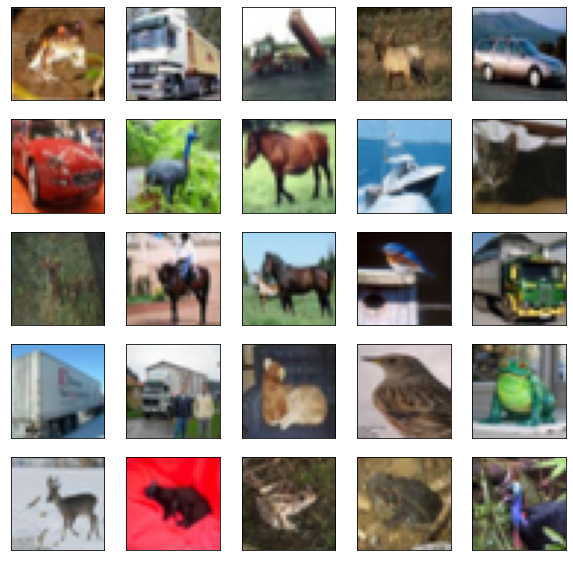

In [677]:
x_train=np.reshape(phi_reg(vx_train[0:25,:],alpha1min,zmin[0:25,:,:]).detach().numpy(),(25,32,32,3))
x2=np.reshape(phi_torch(vx_train[0:25,:],torch.zeros((D1,p,L),dtype=torch.float64)).detach().numpy(),(25,32,32,3))
def showimagesCIFAR(x_train):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
        #plt.title(gamma2)
    plt.show()
showimagesCIFAR(x2)
#showimagesCIFAR(x_train)